# Change in exposure to heatwaves

Heat waves are defined here using the index proposed in Jacob et al. [2013] (but using daily minimum temperature data instead of maximum), as any period of more than 3 consecutive days (i.e 4 or more days) exceeding the 99th percentile of the daily minimum temperature of all DJF/JJA seasons for the recent past (1986-2005). The change in heatwave frequency ∆H is the difference between the projected number of heat waves and the number of heat waves in the recent historic period (1986-2005).
  
The heatwave risk Hˆ is then measured as the change in heatwave frequency
∆H multiplied by the population;

$$
H = ∆H(x,t)P(x,t)
$$

where P(x,t) is the population of people aged over 65 at location x at time t.


## Alternative approach: number of days of heatwave

Instead of simply counting the number of periods over the threshold longer than 3 days, why not simply sum the total number of days of 'heatwave condition'. I beleive this to be a much better indicator since it should capture both the number of heatwaves and the change in length of heatwaves. With the previous method, a 3-week heatwave counts the same as a 4 days one.


The heatwave indicator is therefor in units of 'Days of heatwave conditions'.

The heatwave exposure indicator is in days-person exposed - which can be thought of as the total number of days of heatwave experienced (e.g. 2 people experiencing the same day of heatwave, a total of 2 days of heatwaves have been experienced)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gpd

import xarray as xr
import matplotlib.pyplot as plt

from numba import jit
from cartopy import crs

import population_tools
from config import DATA_SRC, POP_DATA_SRC

import matplotlib as mpl
mpl.rc('figure', titlesize=12)

In [2]:
t_min_file = DATA_SRC / 'weather' / 'ecmwf' / 'era_interim_temperature_day_min.nc'
high_t_reference_file = DATA_SRC / 'lancet' / 'heatwave_high_t_reference.nc'

## Adjust by population over 65

- Use the proportion in 2005 and assume that this does not change significantly in the period of interest from 2000-2015

In [3]:
un_demographics = pd.read_csv(POP_DATA_SRC / 'UN' / 'WPP2015_INT_F2B_Annual_Population_Indicators_Percentage.csv')
un_demographics = un_demographics.set_index('LocID')
un_demographics = un_demographics[un_demographics.Variant == 'Medium']
un_demographics = un_demographics[un_demographics.Time == 2005]

country_shapefile = DATA_SRC / 'GIS' / 'world'/ 'ne_50m_admin_0_countries' / 'ne_50m_admin_0_countries.shp'

# COUNTRY_POLY_SHP
countries = gpd.read_file(str(country_shapefile))
# Translate to match raster coordinates
countries.geometry = countries.translate(xoff=180)

# Remove missing UN A3 code fields, convert to int and set as index
countries.loc[countries.un_a3 == '-099', 'un_a3'] = np.nan
countries.un_a3 = countries.un_a3.astype(float)
countries = countries[np.isfinite(countries.un_a3)]
countries.un_a3 = countries.un_a3.astype(int)
countries = countries.set_index('un_a3')
countries = countries.join(un_demographics['pPopTot_65_100'])



## Rasterize the population over 65 by country onto the population grid

In [4]:
# Load the age percent raster first to save time later
with population_tools.PopulationProjector() as pop:
    age_pct_raster = pop.rasterize_data(countries, 'pPopTot_65_100')
    age_pct_raster *= pop.water_mask.squeeze()
    age_pct_raster /= 100
    age_pct_raster.shape = (*age_pct_raster.shape, 1)

## Load weather data and save minimas

NOTE: only need to do this once

In [ ]:
weather_file = DATA_SRC / 'weather' / 'ecmwf' / 'era_interim_temperature_2m.nc'
era_alltemps = xr.open_dataset(str(weather_file), chunks={'time': 24})
era_allmin = era_alltemps.resample('1D', dim='time', how='min')
era_allmin.to_netcdf(str(t_min_file))

In [17]:
era_alltemps.close()

### Open the saved minimas file

In [4]:
era_allmin = xr.open_dataset(str(t_min_file), chunks={'time': 365})
# era_allmin = xr.open_dataset(str(t_min_file))

## Calculate the 99th percentile 1986-2005

In [21]:
recent_past = era_allmin.sel(time=slice('1986-01-01', '2005-12-31'))
high_t_reference = recent_past.quantile(0.99, dim='time')

In [25]:
high_t_reference.to_netcdf(str(high_t_reference_file))

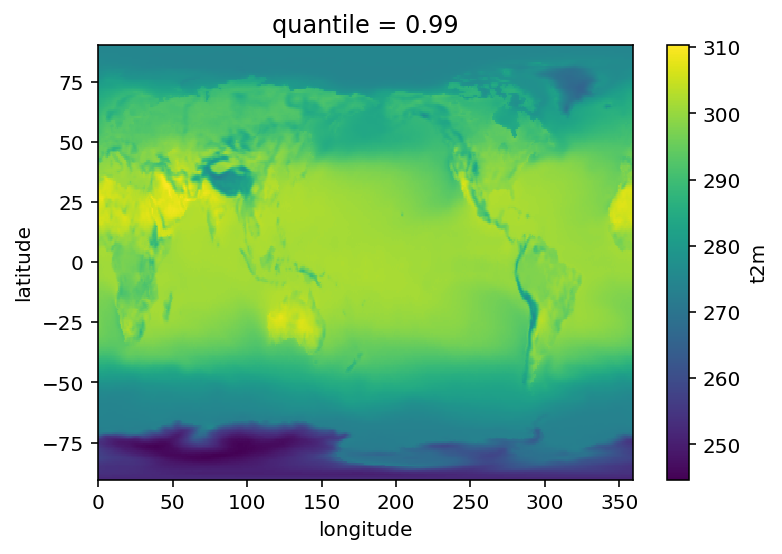

In [97]:
high_t_reference.plot()

### Load the high-t reference file

In [5]:
high_t_reference = xr.open_dataset(str(high_t_reference_file))
high_t_reference = high_t_reference.t2m.load()

## For period of interest, select where t > tref

In [6]:
@jit("int64[:,:](b1[:,:,:])")
def fast_heatwaves_lengths(dataset_year_asbool):
    
    last_slice = None
    accumulator = np.zeros(dataset_year_asbool.shape[1:], dtype=np.int64)
    lengther = np.zeros(dataset_year_asbool.shape[1:], dtype=np.int64)
    
    for i in range(1, dataset_year_asbool.shape[0]):
        last_slice = dataset_year_asbool[i-1, :, :]
        data_slice = dataset_year_asbool[i, :, :]

        # Add to the sequence length counter at all positions
        # above threshold at prev time step
        accumulator[last_slice] += 1
        
        # End of sequence is where prev is true and current is false
        # True where prev and not current
        mask = last_slice & np.logical_not(data_slice)
        
        # Add the length of the accumulator where the sequences are ending and are > 3
        # TODO should the length include the first 3 days?
        lengther[mask & (accumulator > 3)] += accumulator[mask & (accumulator > 3)]
        # Reset the accumulator where current slice is empty
        accumulator[np.logical_not(data_slice)] = 0
            
    return lengther

@jit("int64[:,:](b1[:,:,:])")
def fast_heatwaves_counts(dataset_year_asbool):
    
    last_slice = None
    accumulator = np.zeros(dataset_year_asbool.shape[1:], dtype=np.int64)
    counter = np.zeros(dataset_year_asbool.shape[1:], dtype=np.int64)
    
    for i in range(1, dataset_year_asbool.shape[0]):
        last_slice = dataset_year_asbool[i-1, :, :]
        data_slice = dataset_year_asbool[i, :, :]

        # Add to the sequence length counter at all positions
        # above threshold at prev time step
        accumulator[last_slice] += 1
        
        # End of sequence is where prev is true and current is false
        # True where prev and not current
        mask = last_slice & np.logical_not(data_slice)
        
        # Add one the the counter where the sequences are ending AND > 3
        counter[mask & (accumulator > 3)] += 1
        # Reset the accumulator where current slice is empty
        accumulator[np.logical_not(data_slice)] = 0
            
    return counter


def groups_cutoffs(year, dataset_year, reference):
    
    dataset_year_asbool = xr.ufuncs.isfinite(dataset_year.where(dataset_year > reference)).values

#     counter = fast_groups_cutoffs(dataset_year_asbool)
    counter = fast_heatwaves_lengths(dataset_year_asbool)

    fast_heatwaves_lengths

    counter.shape = (*counter.shape, 1)
    counter = xr.DataArray(counter, 
                            coords=[dataset_year.latitude.values,
                                    dataset_year.longitude.values,
                                    [year]
                                   ], 
                           dims=['latitude', 'longitude', 'time'],
                           name='heatwave_count'
                          )
    
    return counter


def heatwave_for_year(year, temperatures, reference):
    # Do join for each year to save memory
    t_yr = temperatures.sel(time=f'{year}')
    lat_north = temperatures.latitude[temperatures.latitude >= 0]
    lat_south = temperatures.latitude[temperatures.latitude < 0]
    
    tnh = t_yr.sel(latitude=lat_north)
    tnh = tnh.where(t_yr['time.season'] == 'JJA')

    tsh = t_yr.sel(latitude=lat_south)
    tsh = tsh.where(t_yr['time.season'] == 'DJF')

    
    t_yr = xr.concat([tnh, tsh], 
                     dim='latitude')
    t_yr = t_yr.fillna(-9999)
    return groups_cutoffs(year, t_yr, reference)



In [8]:
temperatures = era_allmin.t2m

In [75]:
def _gen():
    years = list(range(1986, 2016))
    for year in years:
        print(year)
        yield heatwave_for_year(year, temperatures, high_t_reference)

heatwaves = xr.concat(_gen(), dim='time')
heatwaves = heatwaves.astype(float)


1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015


In [95]:
heatwaves.to_netcdf(str(DATA_SRC / 'lancet'/'heatwaves_lengths_all_years.nc'))

In [5]:
heatwaves = xr.open_dataarray(str(DATA_SRC / 'lancet'/'heatwaves_lengths_all_years.nc'))

In [6]:
# Take average period to match Temperature Change calculations
heatwaves_historical = heatwaves.sel(time=slice(1986,2008)).mean(dim='time')
heatwaves_delta = heatwaves - heatwaves_historical

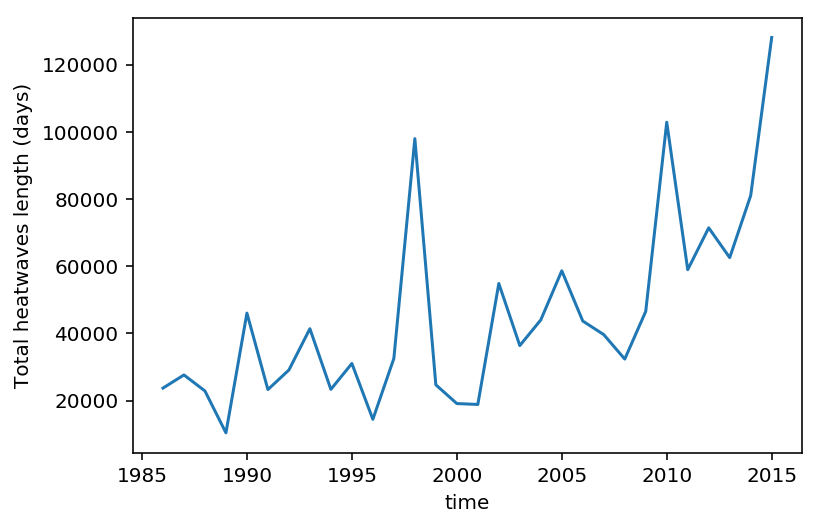

In [27]:
heatwaves.sum(dim=['latitude', 'longitude']).plot()
plt.ylabel('Total heatwaves length (days)')
plt.savefig('total_heatwaves_length.png')

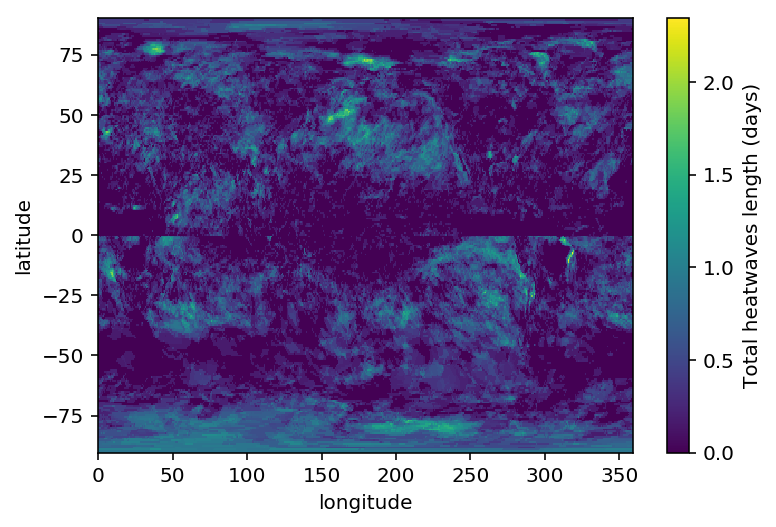

In [85]:
heatwaves_historical.name = 'Total heatwaves length (days)'
heatwaves_historical.plot()

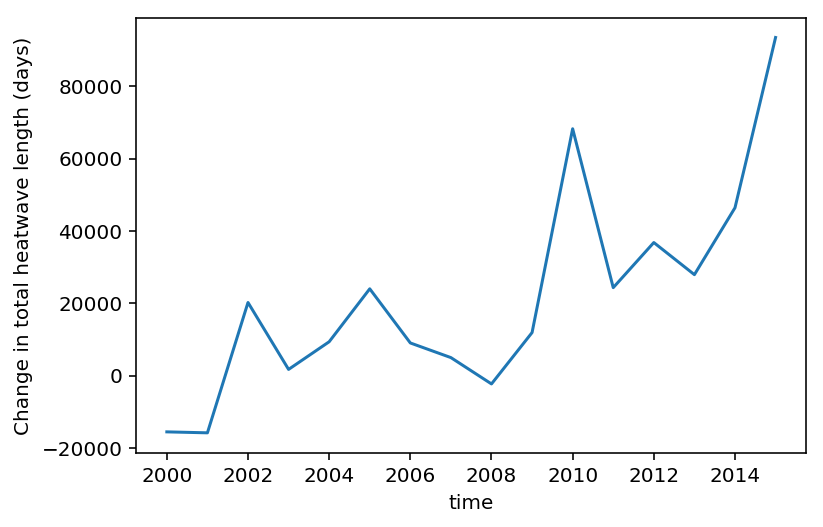

In [98]:
heatwaves_delta.sel(time=slice('2000','2015')).sum(dim=['latitude', 'longitude']).plot()
plt.ylabel('Change in total heatwave length (days)')
plt.savefig('change_total_heatwaves_length.png')

## Project the heatwave change onto the population

In [7]:
def project_heatwaves(heatwaves_delta):
    with population_tools.PopulationProjector(population_tools.PopulationType.count.value) as pop:
        years = list(range(2000, 2016))

        def _gen():
            for year in years:
                print(year)
                yield pop.project(year, heatwaves_delta.sel(time=year)) 
        heatwaves_pop = (xr.concat(_gen(), dim='time') * age_pct_raster).compute()
        heatwaves_pop_ts = heatwaves_pop.sum(dim=['latitude', 'longitude']).compute()
    return heatwaves_pop_ts, heatwaves_pop

heatwaves_pop_ts, heatwaves_pop = project_heatwaves(heatwaves_delta)

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015


/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/array/core.py:2544: RuntimeWarning: invalid value encountered in greater
  return function(*args2, **kwargs)


In [8]:
heatwaves_pop.name = 'experienced_heatwave_days'
heatwaves_pop.to_netcdf(str(DATA_SRC / 'lancet'/'heatwaves_lengths_to_population.nc'))

In [3]:
heatwaves_pop = xr.open_dataarray(str(DATA_SRC / 'lancet'/'heatwaves_lengths_to_population.nc'))

In [36]:
with population_tools.PopulationProjector(population_tools.PopulationType.count.value) as pop:
    pop_sum = (pop.data.population * age_pct_raster).sum(dim=['latitude', 'longitude']).compute()
    pop_mean = (pop.data.population * age_pct_raster).mean(dim=['latitude', 'longitude']).compute()

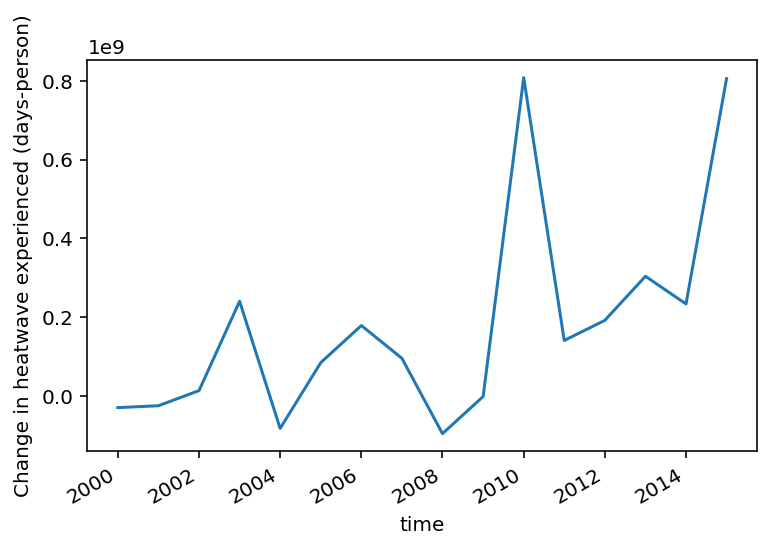

In [37]:
# Plot change in exposure event, where 1 event = 1 heatwave x 1 person
heatwaves_pop_ts.plot()
plt.ylabel('Change in heatwave experienced (days-person)')
plt.savefig('change_total_heatwaves_experienced.png')

In [38]:
v_lower = np.asscalar(heatwaves_pop.quantile(0.02).values)
v_upper = np.asscalar(heatwaves_pop.quantile(0.98).values)

v_both = np.maximum(np.abs(v_lower), v_upper)
v_both = np.round(v_both, 0)

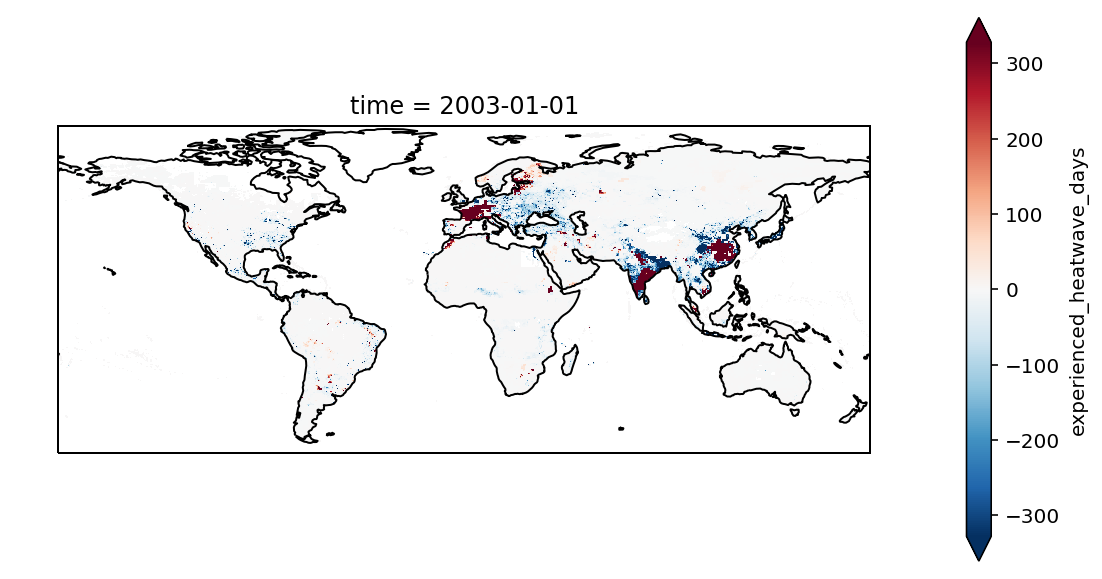

In [46]:
f = plt.figure()
f.set_size_inches(10,5)
ax = plt.axes(projection=crs.PlateCarree())
heatwaves_pop.sel(time='2003').plot(cmap='RdBu_r', vmin=-v_both, vmax=v_both, ax=ax,
                                    transform=crs.PlateCarree())
ax.coastlines();
plt.show()

In [ ]:
p = heatwaves_pop.plot(x='longitude', y='latitude', col='time', 
                       col_wrap=3, cmap='RdBu_r', vmin=-v_both, vmax=v_both,
                    size=2,
                 subplot_kws=dict(projection=crs.PlateCarree())
                      )

for ax in p.axes.flat:
    ax.coastlines()

#     ax.gridlines()

p.cbar.remove()
p.add_colorbar(orientation='horizontal')
# plt.savefig('heatwaves_total_experienced_map.png', dpi=1000)

KeyboardInterrupt: 

ERROR:tornado.general:Uncaught exception, closing connection.
Traceback (most recent call last):
  File "/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/jonathanchambers/miniconda3/envs

## Plot change in mean number of heatwaves experienced per person

In [40]:
heatwaves_pop_mean = (heatwaves_pop / pop_sum)

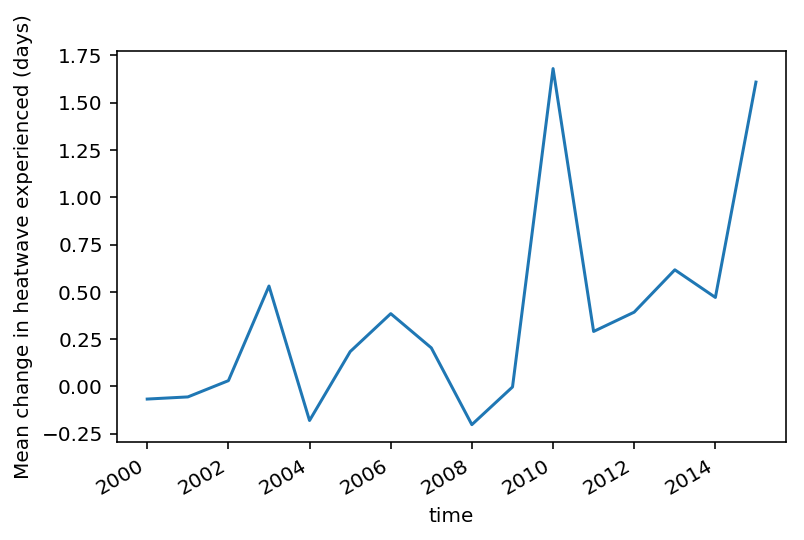

In [44]:
(heatwaves_pop/pop_sum).sum(dim=['latitude', 'longitude']).plot()
plt.ylabel('Mean change in heatwave experienced (days)')
plt.savefig('mean_change_total_heatwaves_experienced.png')

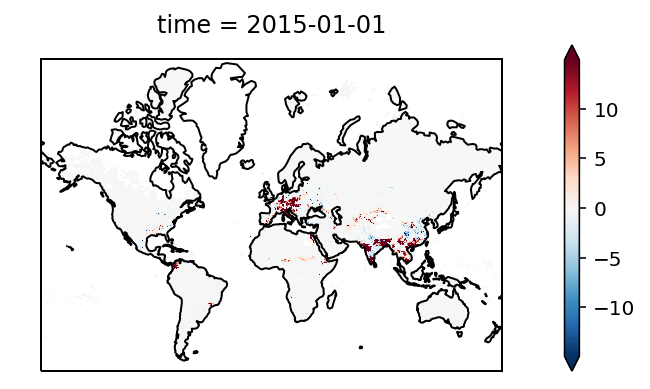

In [42]:
f = plt.figure()
ax = plt.axes(projection=crs.Mercator())
(heatwaves_pop/pop_mean).sel(time='2015').plot(robust=True, ax=ax, transform=crs.PlateCarree())
ax.coastlines();
f.set_size_inches(7,3)

## TODO

Need to get a really good handle on what the 2015 paper shows and make sure that the values make sense

- Projecting onto population DENSITY to give exposure events per km2 does give the expected range of values matching Figure 4C.
- Need to decide if this is actually what we want to see, but at least it corresponds to what was done before. Personally, feel that what matters more is the absolute number of events rather than the events per unit area, since they apply to individual people
- To get the total line, should simply sum events. Doing this sum with population DENSITY also gives a trend in line with Firgure 4D.
- Again, feel that this isn't actually what we want, we want N heatwaves * N people and don't really care about per unit area calculation. Also what does it actually mean to sum per-unit-area values - think that it only makes sense to average them...

## Plots based on Watts et. al 2015 method

This approach normalized per-population density per-unit-area. However the updated method normalises only by population. Note that this makes more sense, especially since taking the of sum of per-unit-area values is a bit wierd.

In [37]:
def project_heatwaves(heatwaves_delta):
    # population_tools.PopulationType.density.value
    with population_tools.PopulationProjector(population_tools.PopulationType.density.value) as pop:
        years = list(range(2000, 2016))

        heatwaves_pop = []

        for year in years:
            print(year)
            hw = pop.project(year, heatwaves_delta.sel(time=year)) * age_pct_raster
            heatwaves_pop.append(hw)
        heatwaves_pop = xr.concat(heatwaves_pop, dim='time').compute()
        heatwaves_pop_ts = heatwaves_pop.sum(dim=['latitude', 'longitude']).compute()
    #     heatwaves_pop = (heatwaves_pop / pop_mean).compute()
    return heatwaves_pop_ts, heatwaves_pop

heatwaves_pop_ts, heatwaves_pop = project_heatwaves(heatwaves_delta)

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015


/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/array/core.py:2544: RuntimeWarning: invalid value encountered in greater
  return function(*args2, **kwargs)


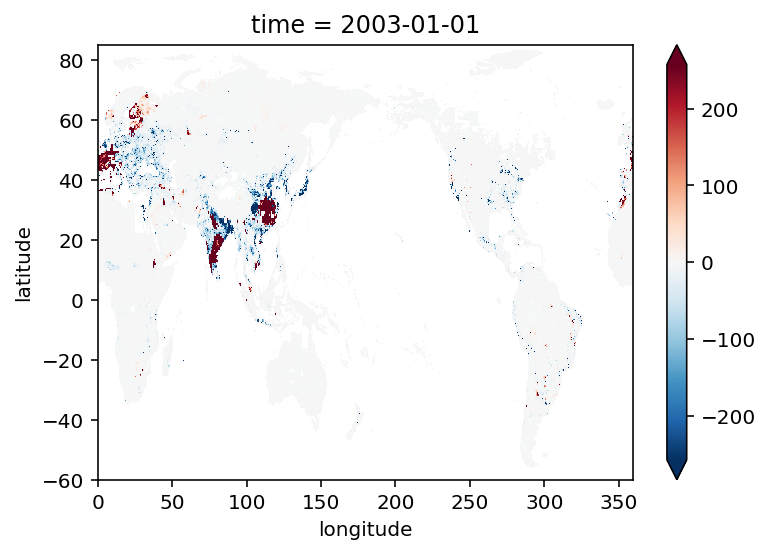

In [38]:
heatwaves_pop.sel(time='2003').plot(robust=True)

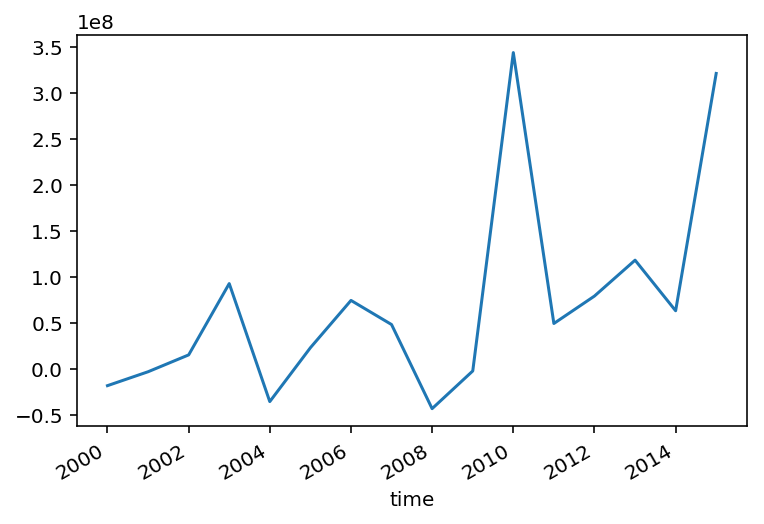

In [39]:
heatwaves_pop_ts.plot()